In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from collections import Counter
import glob
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import train
from random import shuffle
import imp
%matplotlib inline

Using TensorFlow backend.


In [4]:
characters = [k.split('/')[2] for k in glob.glob('./characters/*') if len([p for p in glob.glob(k+'/*') 
                                                                           if 'edited' in p or 'pic_vid' in p]) > 300]
map_characters = dict(enumerate(characters))
print(map_characters)

{0: 'abraham_grampa_simpson', 1: 'bart_simpson', 2: 'charles_montgomery_burns', 3: 'homer_simpson', 4: 'krusty_the_clown', 5: 'lisa_simpson', 6: 'marge_simpson', 7: 'moe_szyslak', 8: 'ned_flanders', 9: 'sideshow_bob'}


In [5]:
imp.reload(train)

## Just creating dataset
X_train, X_test, y_train, y_test = train.get_dataset(save=True)

Train (6893, 64, 64, 3) (6893, 10)
Test (766, 64, 64, 3) (766, 10)
Train :
homer_simpson : 1357 pictures
bart_simpson : 914 pictures
lisa_simpson : 901 pictures
marge_simpson : 880 pictures
charles_montgomery_burns : 576 pictures
moe_szyslak : 485 pictures
krusty_the_clown : 482 pictures
ned_flanders : 479 pictures
abraham_grampa_simpson : 461 pictures
sideshow_bob : 358 pictures


#### Four convulational layers

In [7]:
## Training in the notebook
# X_train, X_test, y_train, y_test = train.get_dataset()
# model, opt = train.create_model(X_train.shape[1:])
# model.compile(loss='categorical_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])
# model, history = train.training(model, X_train, X_test, y_train, y_test, data_augmentation=True)

## Training on AWS
X_train, X_test, y_train, y_test = train.get_dataset(load=True)
model = keras.models.load_model('model2.h5')
with open('./history.pkl', 'rb') as f:
    history = pickle.load(f)
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')

Train (6893, 64, 64, 3) (6893, 10)
Test (766, 64, 64, 3) (766, 10)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.96      0.90      0.93        49
            bart_simpson       0.88      0.90      0.89        92
charles_montgomery_burns       0.84      0.94      0.89        63
           homer_simpson       0.96      0.96      0.96       142
        krusty_the_clown       0.92      0.98      0.95        46
            lisa_simpson       0.97      0.90      0.93       102
           marge_simpson       0.97      0.99      0.98       101
             moe_szyslak       0.98      0.92      0.95        62
            ned_flanders       0.98      0.98      0.98        61
            sideshow_bob       0.98      0.98      0.98        48

             avg / total       0.95      0.95      0.95       766



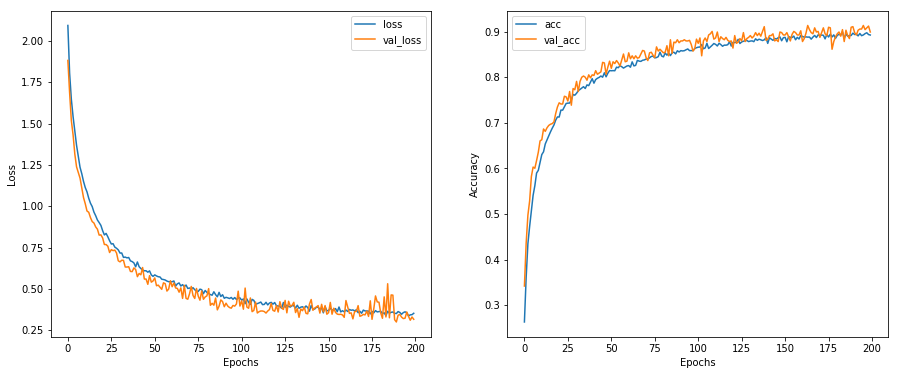

In [18]:
epochs= range(200)
f, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(epochs, history['loss'], label='loss')
ax[0].plot(epochs, history['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, history['acc'], label='acc')
ax[1].plot(epochs, history['val_acc'], label='val_acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

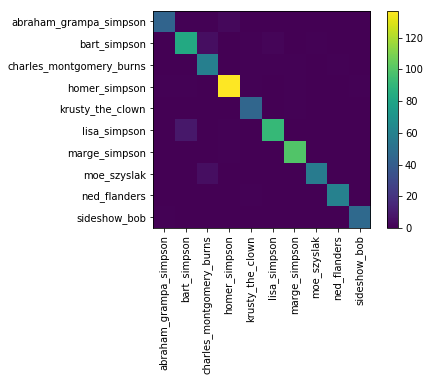

In [8]:
cnf_matrix = sklearn.metrics.confusion_matrix(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1))
classes = list(map_characters.values())
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

#### Six convolutional layers 

In [19]:
## Training on AWS
X_train, X_test, y_train, y_test = train.get_dataset(load=True)
model = keras.models.load_model('model_sixconv.h5')
with open('./history2.pkl', 'rb') as f:
    history = pickle.load(f)
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')

Train (6893, 64, 64, 3) (6893, 10)
Test (766, 64, 64, 3) (766, 10)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.93      0.95      0.94        58
            bart_simpson       0.83      0.89      0.86        89
charles_montgomery_burns       0.87      0.68      0.76        76
           homer_simpson       0.90      0.94      0.92       147
        krusty_the_clown       0.91      0.98      0.94        41
            lisa_simpson       0.90      0.85      0.87       102
           marge_simpson       0.96      0.95      0.96       108
             moe_szyslak       0.80      0.89      0.84        45
            ned_flanders       0.93      0.86      0.89        59
            sideshow_bob       0.84      0.93      0.88        41

             avg / total       0.89      0.89      0.89       766



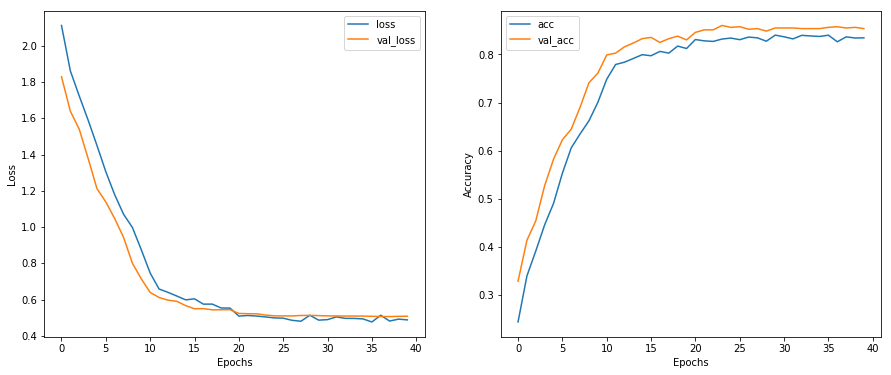

In [21]:
epochs= range(40)
f, ax = plt.subplots(ncols=2, figsize=(15,6))
ax[0].plot(epochs, history['loss'], label='loss')
ax[0].plot(epochs, history['val_loss'], label='val_loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, history['acc'], label='acc')
ax[1].plot(epochs, history['val_acc'], label='val_acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

In [22]:
## -> More overfitting

#### Predict from url

In [340]:
import urllib
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    return image

def plot_and_predict(url, all_perc=False):
    image = url_to_image(url)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    pic = cv2.resize(image, (pic_size,pic_size))
    a = model.predict_proba(pic.reshape(1, pic_size, pic_size,3))[0]
    if all_perc:
        print('\n'.join(['{} : {}%'.format(map_characters[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
    else:
        return map_characters[np.argmax(a)].replace('_',' ').title()

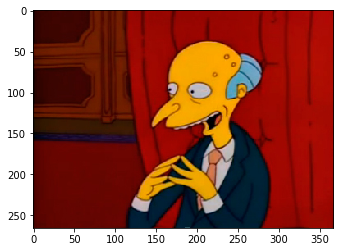

1/1 [==============================] - 0s


'Charles Montgomery Burns'

In [345]:
url = "https://vignette3.wikia.nocookie.net/simpsons/images/2/25/Adult_burns.jpg/revision/latest?cb=20111012170021"
plot_and_predict(url)